In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.base import ClusterMixin
import math
import seaborn as sns
import matplotlib.pyplot as plt
from line_profiler import LineProfiler
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

In [2]:
def profile_print(func_to_call, *args):
    profiler = LineProfiler()
    profiler.add_function(func_to_call)
    profiler.runcall(func_to_call, *args)
    profiler.print_stats()

Мой первоначальный алгоритм

In [144]:
class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=5, metric='euclidean', max_iter=1000, random_state=None):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
    
    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        def maby_my_metric(w1 , w2):
            ans = 0
            base_size = int (X.shape[1])
            for i in xrange(base_size):
                   ans += (w1[i] - w2[i]) ** 2
            return ans ** 0.5
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0],dtype=int)
        
        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        
        ## Your Code Here
        Eps = 0.00001
        
        labels_size = int(self.labels.shape[0])
        for i in xrange(self.k):
            self.centroids[i] = X[np.random.randint(0,labels_size)] * np.random.sample() + np.random.sample()
        centroids_old = np.copy(self.centroids)
     
       
        for i in xrange(labels_size):
            self.labels[i] = 0
        for step in xrange(self.max_iter):
          
            for i in xrange(labels_size):
                for j in xrange(self.k):
                    if (maby_my_metric(X[i] , self.centroids[self.labels[i]]) > 
                        maby_my_metric(X[i] , self.centroids[j])):
                        self.labels[i] = j;
            centr = [0 for i in xrange(self.k)]
            lens  = [0 for i in xrange(self.k)]
            for i in xrange(labels_size):
                centr[self.labels[i]] += X[i]
                lens[self.labels[i]] += math.fabs(maby_my_metric(X[i], self.centroids[self.labels[i]]))
            
            for i in xrange(self.k):
                
                if lens[i] != 0 :
                    self.centroids[i] = centr[i] / lens[i]
                
            delta = math.fabs(maby_my_metric(self.centroids[0],centroids_old[0]))
            for i in xrange(self.k):
                delta = max(delta, math.fabs(maby_my_metric(self.centroids[i],centroids_old[i])))
           
            if delta < Eps:
                break
           
            centroids_old = np.copy(self.centroids)
            
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        ret_labels = []
        labels_size = int(self.labels.shape[0])
        for i in xrange(labels_size):
            ret_labels.append(self.labels[i]+1)
        return ret_labels
    

Векторизуем вычисления, т.е. улучшим функцию вычисления растояния и немного улучшим вычисления в методе fit


In [87]:
A=np.array([1,2,3])
A[1]

2

In [106]:
model = Kmeans() #  в методе установлен k=9 для второго номера, его можно изменять для 1 номера
model.fit(X, y)
y1 = model.predict(X,y)


### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, желатено испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

In [4]:
from sklearn.datasets import make_blobs

In [121]:
X, y = make_blobs(n_samples=30, n_features=3, centers=5, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

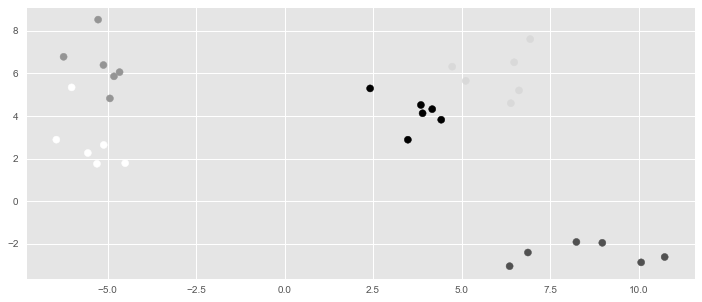

In [129]:
plt.scatter(X[:,0], X[:, 1], c=y)

#### Задание 2 (1 балл) 

Проверьте вашу имплементацию на простых данных

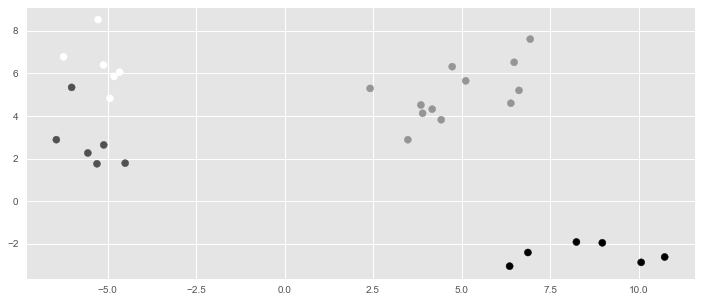

In [145]:
model = Kmeans()
model.fit(X, y)
y1 = model.predict(X,y)
plt.scatter(X[:,0], X[:, 1], c=y1)


In [123]:
%%timeit
model.fit(X,y)

100 loops, best of 3: 6.5 ms per loop


In [11]:
profile_print(model.fit, X, y)

Timer unit: 1e-06 s

Total time: 0.021281 s
File: <ipython-input-3-73f89b1129e1>
Function: fit at line 17

Line #      Hits         Time  Per Hit   % Time  Line Contents
    17                                               def fit(self, X, y=None):
    18                                                   """
    19                                                   Процедура обучения k-means
    20                                                   """
    21         1            5      5.0      0.0          def maby_my_metric(w1 , w2):
    22                                                       ans = 0
    23                                                       base_size = int (X.shape[1])
    24                                                       for i in xrange(base_size):
    25                                                              ans += (w1[i] - w2[i]) ** 2
    26                                                       return ans ** 0.5
    27                              